In [1]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0+cu101'

In [2]:
data_path = '../input/lish-moa/'

In [3]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 777


# load df

In [4]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [5]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14261,id_a6a4f3626,trt_cp,24,D2,-0.3265,0.1577,-0.3381,0.1789,0.2595,0.7117,...,0,0,0,0,0,0,0,0,0,0
14266,id_a6b456ebb,trt_cp,24,D1,-0.7239,0.0713,0.2250,0.5864,2.6280,-0.4762,...,0,0,0,0,0,0,0,0,0,0
5119,id_3bd739795,trt_cp,24,D1,0.5283,1.2350,2.7150,-0.0206,0.5865,0.2824,...,0,0,0,0,0,0,0,0,0,0
692,id_07b7426b2,trt_cp,24,D1,-0.2856,-0.6573,1.8890,-0.3083,-0.5899,0.5369,...,0,0,0,0,0,0,0,0,0,0
6833,id_4fbf1ada4,trt_cp,72,D2,0.9492,-0.5027,-0.0934,-2.2830,-0.1903,0.0230,...,0,0,0,0,0,0,0,0,0,0
7051,id_52620ac73,trt_cp,24,D1,-0.4717,-0.2592,-0.5129,0.0462,0.5863,-0.6585,...,0,0,0,0,0,0,0,0,0,0
13131,id_995a3b2d4,trt_cp,48,D1,2.4190,-1.1380,-0.4596,-0.1602,2.5480,1.5230,...,0,0,0,0,0,0,0,0,0,0
2435,id_1c33757b3,trt_cp,24,D1,-0.0171,-0.0432,-0.4036,-0.6486,-0.7183,-0.5947,...,0,0,0,0,0,0,0,0,0,0
10021,id_7514b50fb,trt_cp,48,D1,0.5772,0.8006,1.5080,-0.8161,-0.1879,-0.1965,...,0,0,0,0,0,0,0,0,0,0
13768,id_a0ad27715,trt_cp,48,D2,0.2120,0.2485,1.0300,-1.0730,-0.0180,-1.7210,...,0,0,0,0,0,0,0,0,0,0


# cv

In [6]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [7]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [8]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [9]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [10]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 512
    dropout = 0.5
    lr = 1e-2
    wd = 1e-6
    bs = 32
    epochs = 30
    feature_cols = feature_cols
    target_cols = y_keys 

In [11]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x).sigmoid()

In [12]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp),
                             axis=1), axis=0)
    return score


def criterion(preds, ys):
    return F.binary_cross_entropy(preds, ys)

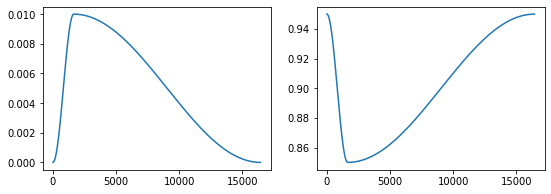

In [13]:
%%capture --no-display
# show_learning_rate_scheduler
cfg = CFG
model = MLP(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                          pct_start=0.1,
                                          div_factor=1e3,
                                          max_lr=1e-2,
                                          epochs=cfg.epochs,
                                          steps_per_epoch=len(trn_loader))


def show_learning_rate_scheduler():
    lrs = []
    moms = []
    for i in range(cfg.epochs * len(trn_loader)):
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step(epoch=i)

    plt.figure(figsize=(9, 3))
    plt.subplot(121)
    plt.plot(lrs)
    plt.subplot(122)
    plt.plot(moms)


show_learning_rate_scheduler()

# train

In [14]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        scheduler.step()

        # metric
        metric = compute_metric(preds.detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)

        # metric
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)

        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    # metrics
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')

    plt.title(f'fold{fold_num}')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    plt.show()
    
    # loss
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')

    plt.title(f'fold{fold_num}')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    plt.show()

In [15]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                              pct_start=0.1,
                                              div_factor=1e3,
                                              max_lr=1e-2,
                                              epochs=cfg.epochs,
                                              steps_per_epoch=len(trn_loader))

    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lr': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, model, optimizer, scheduler, mb)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_loss < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_loss}')
            best_loss = val_loss
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx], trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.412663,0.4126631294,0.021077,0.0210767157,0:4
2,0.022511,0.0224316726,0.019487,0.0194869528,0:3
3,0.021921,0.0217344139,0.018483,0.0184831060,0:3
4,0.019871,0.0198708040,0.017678,0.0176784932,0:3
5,0.018567,0.0185665118,0.017441,0.0174409783,0:3
6,0.017980,0.0179795735,0.017198,0.0171980457,0:3
7,0.017659,0.0176594713,0.017189,0.0171889873,0:3
8,0.017665,0.0176648896,0.017046,0.0170457754,0:3
9,0.017558,0.0175583068,0.016919,0.0169191365,0:3
10,0.017679,0.0176785084,0.017138,0.0171382519,0:3


epoch1 save best model... 0.021076716080409792
epoch2 save best model... 0.019486952888734792
epoch3 save best model... 0.01848310634307139
epoch4 save best model... 0.01767849338183642
epoch5 save best model... 0.017440978467362617
epoch6 save best model... 0.017198045895454008
epoch7 save best model... 0.017188987421860456
epoch8 save best model... 0.017045775414836976
epoch9 save best model... 0.016919136726231673
epoch17 save best model... 0.016810395659832177
epoch18 save best model... 0.016773749516687118
epoch19 save best model... 0.016521620218364143
epoch21 save best model... 0.016431964114987225
epoch22 save best model... 0.01628978438548116
epoch23 save best model... 0.01625831509624228
epoch24 save best model... 0.016220558350290553
fold0 score: 0.01622055821495906


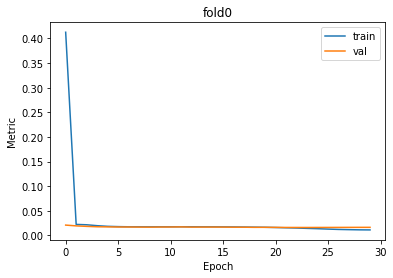

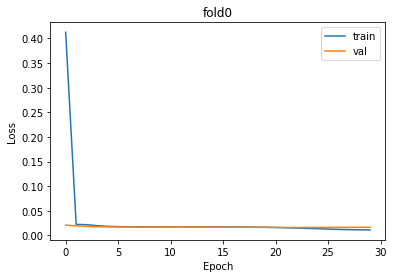

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.410753,0.4107529634,0.021799,0.0217990605,0:3
2,0.022052,0.0220522051,0.019969,0.0199689352,0:3
3,0.021768,0.0215999427,0.019062,0.0190620325,0:3
4,0.019661,0.0196252523,0.017866,0.0178658585,0:3
5,0.018357,0.0183572448,0.017604,0.0176038242,0:3
6,0.017865,0.0178654235,0.017354,0.0173542948,0:3
7,0.017695,0.0176950238,0.017533,0.0175326418,0:3
8,0.017561,0.0175612387,0.017460,0.0174604686,0:3
9,0.017468,0.0174676601,0.017348,0.0173477056,0:3
10,0.017515,0.0175152454,0.017486,0.0174860104,0:3


epoch1 save best model... 0.021799060865119693
epoch2 save best model... 0.01996913157262572
epoch3 save best model... 0.01906203288660489
epoch4 save best model... 0.01786585872465357
epoch5 save best model... 0.0176038244740448
epoch6 save best model... 0.01735429525100362
epoch9 save best model... 0.017347705792181582
epoch11 save best model... 0.017240166862313392
epoch15 save best model... 0.017170883864537814
epoch17 save best model... 0.017165460160579706
epoch18 save best model... 0.017002768643110427
epoch19 save best model... 0.016845674469377816
epoch20 save best model... 0.016828338731242412
epoch21 save best model... 0.01666027481976865
epoch22 save best model... 0.016600641227815547
epoch24 save best model... 0.016545771782223443
fold1 score: 0.016545771576706524


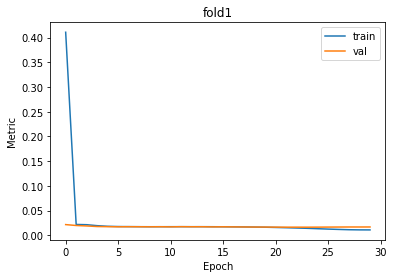

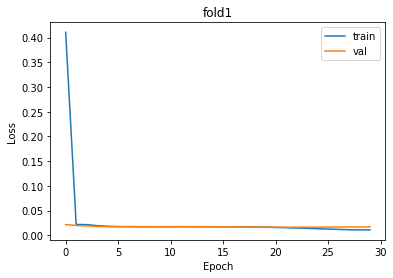

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.408675,0.4086747110,0.021666,0.0216655962,0:3
2,0.022232,0.0221595504,0.019911,0.0199114259,0:3
3,0.021978,0.0217930176,0.019605,0.0194598800,0:3
4,0.019948,0.0199109773,0.017857,0.0178568865,0:3
5,0.018492,0.0184919055,0.017409,0.0174088214,0:3
6,0.017994,0.0179938161,0.017195,0.0171945779,0:3
7,0.017765,0.0177653823,0.017282,0.0172816293,0:3
8,0.017687,0.0176871191,0.017391,0.0173914351,0:3
9,0.017718,0.0177182366,0.017010,0.0170101637,0:3
10,0.017632,0.0176322570,0.017160,0.0171598490,0:3


epoch1 save best model... 0.021665596582910472
epoch2 save best model... 0.01991142736975758
epoch3 save best model... 0.019604684464594423
epoch4 save best model... 0.01785688670375443
epoch5 save best model... 0.01740882144682831
epoch6 save best model... 0.017194578198745328
epoch9 save best model... 0.0170101639688419
epoch15 save best model... 0.01697269180633839
epoch17 save best model... 0.016844869694634543
epoch18 save best model... 0.016831275767216613
epoch19 save best model... 0.016737582867145606
epoch20 save best model... 0.016713171359385017
epoch21 save best model... 0.016435629394950246
epoch22 save best model... 0.016342660978115632
fold2 score: 0.016342660672391655


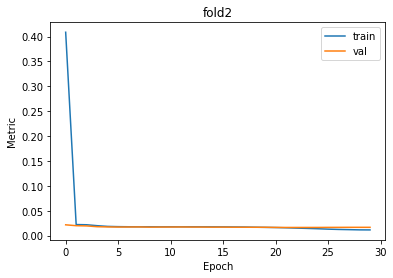

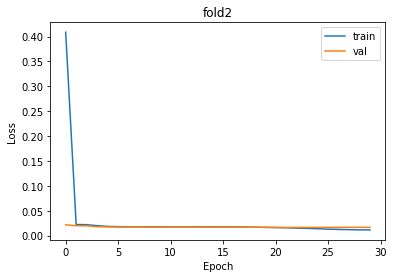

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.410471,0.4104706674,0.021204,0.0212043068,0:3
2,0.022093,0.0220022107,0.019744,0.0197440187,0:3
3,0.021970,0.0217331693,0.018978,0.0189053897,0:3
4,0.019785,0.0197488180,0.018095,0.0180954048,0:3
5,0.018459,0.0184589555,0.017518,0.0175176301,0:3
6,0.017888,0.0178882533,0.017491,0.0174909062,0:3
7,0.017568,0.0175677490,0.017257,0.0172570774,0:3
8,0.017519,0.0175186185,0.017272,0.0172722858,0:3
9,0.017556,0.0175555274,0.017340,0.0173400478,0:3
10,0.017555,0.0175553729,0.017171,0.0171711357,0:3


epoch1 save best model... 0.021204307010494902
epoch2 save best model... 0.01974401904783447
epoch3 save best model... 0.018977775572797024
epoch4 save best model... 0.01809540501836017
epoch5 save best model... 0.01751763027305619
epoch6 save best model... 0.017490906265812473
epoch7 save best model... 0.01725707748281114
epoch10 save best model... 0.017171135752256067
epoch16 save best model... 0.017135175986635522
epoch18 save best model... 0.016936341114342213
epoch19 save best model... 0.016812871952789382
epoch21 save best model... 0.016658597662281203
epoch22 save best model... 0.016585239811730414
epoch23 save best model... 0.016438009447348145
epoch24 save best model... 0.01643465775572154
fold3 score: 0.016434657423647095


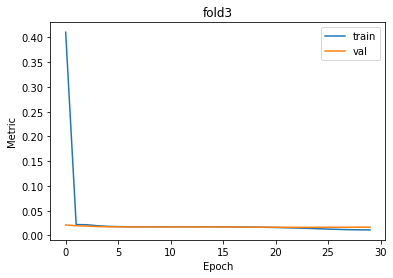

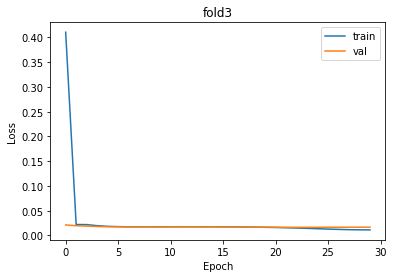

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.410767,0.4107669442,0.021564,0.0215637026,0:3
2,0.022617,0.0225424505,0.019141,0.0191414361,0:3
3,0.021936,0.0216808833,0.018714,0.0187142852,0:3
4,0.019643,0.0196429028,0.018404,0.0184039119,0:3
5,0.018375,0.0183752456,0.017448,0.0174476576,0:3
6,0.017906,0.0179063091,0.017234,0.0172336131,0:3
7,0.017700,0.0176998526,0.017184,0.0171835533,0:3
8,0.017592,0.0175923501,0.017195,0.0171951817,0:3
9,0.017590,0.0175899269,0.017197,0.0171971162,0:3
10,0.017521,0.0175208904,0.017285,0.0172123586,0:3


epoch1 save best model... 0.021563702790333903
epoch2 save best model... 0.019141436255365137
epoch3 save best model... 0.018714285406850464
epoch4 save best model... 0.018403911847697574
epoch5 save best model... 0.01744765769647846
epoch6 save best model... 0.017233613376550223
epoch7 save best model... 0.017183553397757317
epoch14 save best model... 0.01716445561048653
epoch15 save best model... 0.017150899451777578
epoch17 save best model... 0.0170464882075549
epoch18 save best model... 0.01690084355584174
epoch19 save best model... 0.01674679320661992
epoch21 save best model... 0.01672091089222996
epoch22 save best model... 0.016520058479932282
epoch23 save best model... 0.01641951942846077
fold4 score: 0.016419519206548015


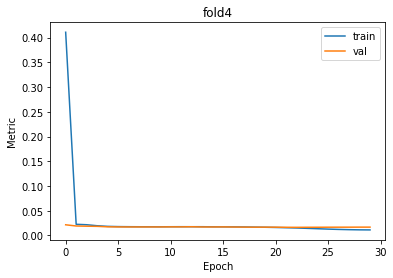

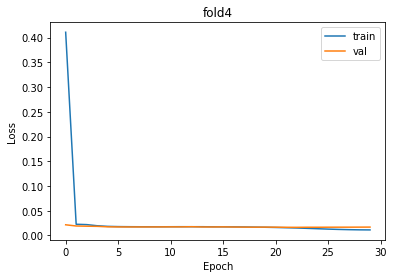

CV score: 0.01639262871840344


In [16]:
oof, predictions = run_kfold_nn(CFG, trn_df, test_df, CFG.feature_cols, CFG.target_cols, n_fold=5)

In [17]:
trn_df[y_keys] = oof
trn_df[['sig_id'] + y_keys].to_csv('oof.csv', index=False)

test_df[y_keys] = pd.DataFrame(predictions)
test_df[['sig_id'] + y_keys].to_csv('pred.csv', index=False)

In [18]:
# Final result with 'cp_type'=='ctl_vehicle' data
result = trn_tar_df.drop(columns=y_keys).merge(trn_df[['sig_id']+y_keys], on='sig_id', how='left').fillna(0)

ys = trn_tar_df[y_keys].values
preds = result[y_keys].values

score = metric(preds, ys)
logger.info(f"Final result: {score}")

NameError: name 'metric' is not defined

In [ ]:
sub = sub_df.drop(columns=y_keys).merge(test_df[['sig_id'] + y_keys], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()